# Gabor function
> Cite:https://arxiv.org/ftp/arxiv/papers/1904/1904.13204.pdf

Gabor function is a complex sinusoid modulated by Gaussian, which satisfies the requirements of monotonicity and differentiability, i.e.
$$g(x,y,\omega,\theta,\psi,\sigma)=exp(-\frac{x'^{2}+y'^{2}}{2\sigma^2})exp(i(\omega x'+\psi))$$
$$x'=xcos\theta+ysin\theta$$
$$y'=-xcos\theta+ycos\theta$$
However, in this work, we used real values of Gabor function i.e.
$$g(x,y,\omega,\theta,\psi,\sigma)=exp(-\frac{x'^{2}+y'^{2}}{2\sigma^2})cos(\omega x'+\psi)$$
In real image processing applications, the features are usually extracted using a bank of Gabor filters, which parameters are set according to the approach proposed in [1]. Frequencies $\omega_{n}$ and orientations $\theta_{m}$ of the Gabor filters are obtained by the following equations:
$$\omega_{n}=\frac{\pi}{2}\sqrt{2}^{-(n-1)},n=1,2,...,5$$
$$\theta_{m}=\frac{\pi}{8}(m-1),m=1,2,...,8$$
The $\psi$ is set by uniform distribution $U(0,\pi)$.
The $\sigma$ is set by $\sigma\approx\pi/\omega$, which allows to define the relationship between $\sigma$ and $\omega$.

Classical Gabor filters give rise to important difficulties when implemented in multiresolution.
- Filters overlap more importantly in the low frequencies than in the higher ones yielding a non-uniform coverage of the Fourier domain.
- Gabor filters have not zero mean, they are then affected by DC components.
The log-Gabor filters lack DC components and can yield a fairly uniform coverage of the frequency domain in an octave scale multiresolution scheme (Field, 1987). The log-Gabor filters are defined in the log-polar coordinates of the Fourier domain as Gaussians shifted from the origin:
$$G_{(s,t)}(\rho,\theta)=exp((\frac{\rho-\rho_{s}}{\sigma_{\rho}})^2)exp((\frac{\theta-\theta_{s}}{\sigma_{\theta}})^2)$$
where $(\rho,\theta)$ are the log-polar coordinates (in log2 scale, indicating the filters are organized in octave scales);
$n_{s}=5$ is the number of scales of the multiresolution scheme and $n_{t}=8$ is the number of orientations as a typical value.
$(\rho_{s},\theta_{(s,t)})$ are the coordinates of the center of the filter;
$(\sigma_{\rho},\sigma_{\theta})$ are the bandwidths in $\rho$ and $\theta$, common for all filters.
with 
$$\rho_{s}=log_{2}(n_{s})-s$$
$$\theta_{(s,t)}=\begin{cases}\frac{\pi}{n_t} t & \text { if } \mathrm{s} \text { is odd } \\ \frac{\pi}{n_t}\left(t+\frac{1}{2}\right) & \text { if } \mathrm{s} \text { is even }\end{cases}$$
$$(\sigma_{\rho},\sigma_{\theta})=0.996(\sqrt{\frac{2}{3}},\frac{1}{\sqrt{2}}\frac{\pi}{n_{t}})$$
where $s\in {1,...,n_{s}}$ and $t\in {1,...,n_{t}}$ indexes the scale and the orientation of the filter, respectively.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
## LOW LEVEL OPERATIONS
pe = {
# Image
'N_X' : 64, # size of images
'N_Y' : 64, # size of images
#PATHs
'figsize': 14.,
# Log-Gabor
'base_levels':1.618,
'n_theta' : 24, # number of (unoriented) angles between 0. radians (included) and np.pi radians (excluded)
'B_sf' : .4, # 1.5 in Geisler
'B_theta' : 3.14159/18.,
}


class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__
pe = Dict(pe)

# from https://github.com/bicv/LogGabor/tree/217f5e91a9b3ffc23371f2f5d6c8f5a434823d34 
def fourier_grid(pe):
    fx, fy = np.mgrid[(-pe.N_X//2):(pe.N_X+1)//2, (-pe.N_Y//2):(pe.N_Y+1)//2]
    fx, fy = fx*1./pe.N_X, fy*1./pe.N_Y
    return fx, fy

def frequency_radius(pe):
#         N_X, N_Y = self.f_x.shape[0], self.f_y.shape[1]
    f_x, f_y = fourier_grid(pe)
    R2 = f_x**2 + f_y**2
    R2[(pe.N_X+1)//2 , (pe.N_Y+1)//2] = 1e-12 # to avoid errors when dividing by frequency
    return np.sqrt(R2)

def band(sf_0, B_sf):
    f = frequency_radius(pe)
    if sf_0 == 0.:
        return 1.
    else:
        # see http://en.wikipedia.org/wiki/Log-normal_distribution
        env = 1./f*np.exp(-.5*(np.log(f/sf_0)**2)/B_sf**2)
        # env = 1./f*np.exp(-.5*((f/sf_0)**2)/B_sf**2)
    return env

def frequency_angle(pe):
    f_x, f_y = fourier_grid(pe)
    return np.arctan2(f_x, f_y)
        
def orientation(theta, B_theta):
    f_theta = frequency_angle(pe)
    if B_theta is np.inf: # for large bandwidth, returns a strictly flat envelope
        enveloppe_orientation = 1.
    else: # non pathological case
        cos_angle = np.cos(f_theta-theta)
        enveloppe_orientation = np.exp(cos_angle/B_theta**2)
    return enveloppe_orientation

def retina(df=.07, sigma=.5):
    f = frequency_radius(pe)
    N_X = pe.N_X
    # removing high frequencies in the corners
    env = (1-np.exp((f-.5)/(.5*df)))*(f<.5)
    # removing low frequencies
    env *= 1-np.exp(-.5*(f**2)/((sigma/N_X)**2))
    return env

def trans(u, v):
    f_x, f_y = fourier_grid(pe)
    return np.exp(-1j*2*np.pi*(u*f_x + v*f_y))

## MID LEVEL OPERATIONS
def loggabor(x_pos, y_pos, sf_0, B_sf, theta, B_theta, preprocess=True):
    f_mask = retina()
    env = np.multiply(band(sf_0, B_sf), orientation(theta, B_theta))
    if not(x_pos==0.) and not(y_pos==0.): # bypass translation whenever none is needed
            env = env.astype(np.complex128) * trans(x_pos*1., y_pos*1.)
    if preprocess : env *= f_mask # retina processing
    # normalizing energy:
    env /= np.sqrt((np.abs(env)**2).mean())
    # in the case a a single bump (see ``orientation``), we should compensate the fact that the distribution gets complex:
    env *= np.sqrt(2.)
    return env

from numpy.fft import fft2, fftshift, ifft2, ifftshift
# Fourier number crunching
def invert(FT_image, full=False):
    if full:
        return ifft2(ifftshift(FT_image))
    else:
        return ifft2(ifftshift(FT_image)).real

# Image
def normalize(image, center=True, use_max=True):
    image_ = image.copy()
    if center: image_ -= np.median(image_)
    if use_max:
        if np.max(np.abs(image_.ravel()))>0: image_ /= np.max(np.abs(image_.ravel()))
    else:
        if image_.std()>0: image_ /= image_.std() # self.energy(image_)**.5
    return image_

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


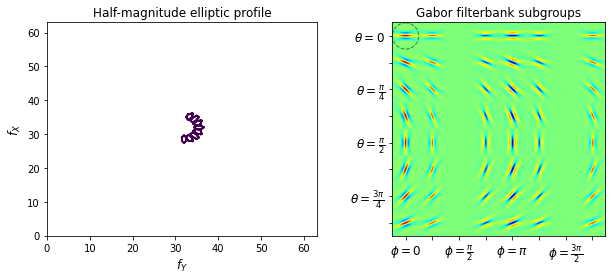

In [2]:
samples = 8
fig, ax = plt.subplots(1, 2, figsize=(9,4))
image_gabor = np.zeros((pe.N_X*samples, pe.N_X*samples))
env_total = np.zeros((pe.N_X, pe.N_X))
for i in range(samples):
    for j in range(samples):
        #params = {'sf_0':2**(2*j)/128., 'B_sf':pe.B_sf, 'theta':i*np.pi/4, 'B_theta':pe.B_theta}
        params = {'sf_0':0.06, 'B_sf':0.4, 'theta':(i-4)*np.pi/8, 'B_theta':3.14159/16}
        # loggabor takes as args: u, v, sf_0, B_sf, theta, B_theta)
        FT_lg = loggabor(pe.N_X/2, pe.N_X/2, **params)
        env = np.absolute(FT_lg)**2
        env_total += env
        ax[0].contour(env, levels=[env.max()/2])

        image_temp = invert(FT_lg) * np.exp(-1j*2*np.pi*j/samples)
        image_gabor[(i*pe.N_X):(i*pe.N_X+pe.N_X), (j*pe.N_X):(j*pe.N_X+pe.N_X)] = image_temp
image_gabor /= np.abs(image_gabor).max()
ax[0].set_xlabel(r'$f_Y$', fontsize=12)
ax[0].set_ylabel(r'$f_X$', fontsize=12)
ax[0].set_title('Half-magnitude elliptic profile')

ax[-1].invert_yaxis()
image = normalize(image_gabor, center=True, use_max=True)
ax[-1].imshow(image,cmap='jet')
ax[-1].set_xticks(np.arange(samples)*pe.N_X + pe.N_X/2)
ax[-1].set_xticklabels([r'$\phi=0$', '', r'$\phi=\frac{\pi}{2}$', '', r'$\phi=\pi$', '', r'$\phi=\frac{3\pi}{2}$',''], fontsize=12)
ax[-1].set_yticks(np.arange(samples)*pe.N_X + pe.N_X/2)
ax[-1].set_yticklabels([r'$\theta=0$', '', r'$\theta=\frac{\pi}{4}$', '', r'$\theta=\frac{\pi}{2}$', '', r'$\theta=\frac{3\pi}{4}$',''], fontsize=12)
ax[-1].grid(False)
linewidth_mask = 1
circ = plt.Circle((.5*pe.N_Y, .5*pe.N_Y), radius=0.5*pe.N_Y-linewidth_mask/2., fill=False, facecolor='none', edgecolor = 'black', alpha = 0.5, ls='dashed', lw=linewidth_mask)
ax[-1].add_patch(circ)
ax[-1].set_title('Gabor filterbank subgroups')
plt.tight_layout()